In [33]:
# import required libraries
# import os
# import numpy as np
import glob
import torch
import pathlib
import torchvision
import torch.nn as nn
from PIL import Image
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import transforms


In [34]:
# checking if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [35]:
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],   # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])


In [36]:
# Path for training and testing directory
train_path = 'E:\\7_Seventh Sem\AI\Building Type Classification\Data set\Data set\seg_train'
test_path = 'E:\\7_Seventh Sem\AI\Building Type Classification\Data set\Data set\seg_test'

# load training dataset
load_train = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer),
    batch_size=32, shuffle=True
)

# load test dataset
load_test = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer),
    batch_size=12, shuffle=True
)


In [37]:
# available categories of buildings
root = pathlib.Path(train_path)
categories = sorted([j.name.split('/')[-1] for j in root.iterdir()])

# print all the categories
print(categories)


['Apartments', 'Religious buildings', 'individual buildings', 'office buildings', 'shops', 'slums']


In [38]:
# CNN Network
class ConvNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNet, self).__init__()

        # Output size after convolution filter
        # ((w-f+2P)/s) +1

        # Input shape= (32,3,150,150)

        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Shape= (32,12,150,150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        #Shape= (32,12,150,150)
        self.relu1 = nn.ReLU()
        #Shape= (32,12,150,150)

        self.pool = nn.MaxPool2d(kernel_size=2)
        # Reduce the image size be factor 2
        #Shape= (32,12,75,75)

        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=64, kernel_size=3, stride=1, padding=1)
        #Shape= (32,64,75,75)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        #Shape= (32,64,75,75)
        self.relu2 = nn.ReLU()
        #Shape= (32,64,75,75)

        self.fc = nn.Linear(in_features=75 * 75 * 64, out_features=num_classes)

        # Feed forwad function

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.pool(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)

        # Above output will be in matrix form, with shape (32,64,75,75)
        output = output.view(-1, 64*75*75)
        output = self.fc(output)
        return output


In [39]:
model = ConvNet(num_classes=6).to(device)


In [40]:
# Optmizer and loss function
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()


In [41]:
epoch_count = 15
train_count = len(glob.glob(train_path+'/**/*.jpg'))
test_count = len(glob.glob(test_path+'/**/*.jpg'))

# get the size of train and test dataset
print(train_count, test_count)


521 120


In [42]:
# Model training and saving best model
best_acc = 0.0

for epoch in range(epoch_count):

    # Evaluation and training on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(load_train):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data*images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count

    # Evaluation on testing dataset
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(load_test):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy/test_count

    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss) +
          ' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    # Save the best model
    if test_accuracy > best_acc:
        torch.save(model.state_dict(), 'best_check.model')
        best_acc = test_accuracy


Epoch: 0 Train Loss: tensor(3.9411) Train Accuracy: 0.3416506717850288 Test Accuracy: 0.25833333333333336
Epoch: 1 Train Loss: tensor(1.8858) Train Accuracy: 0.5969289827255279 Test Accuracy: 0.45
Epoch: 2 Train Loss: tensor(1.5471) Train Accuracy: 0.6621880998080614 Test Accuracy: 0.45
Epoch: 3 Train Loss: tensor(0.5541) Train Accuracy: 0.8272552783109405 Test Accuracy: 0.525
Epoch: 4 Train Loss: tensor(0.3375) Train Accuracy: 0.8809980806142035 Test Accuracy: 0.4083333333333333
Epoch: 5 Train Loss: tensor(0.4231) Train Accuracy: 0.8809980806142035 Test Accuracy: 0.5583333333333333
Epoch: 6 Train Loss: tensor(0.1316) Train Accuracy: 0.9558541266794626 Test Accuracy: 0.5833333333333334
Epoch: 7 Train Loss: tensor(0.1527) Train Accuracy: 0.9424184261036468 Test Accuracy: 0.5166666666666667
Epoch: 8 Train Loss: tensor(0.1025) Train Accuracy: 0.9673704414587332 Test Accuracy: 0.49166666666666664
Epoch: 9 Train Loss: tensor(0.0620) Train Accuracy: 0.9788867562380038 Test Accuracy: 0.516666

In [43]:
best_acc

0.5833333333333334

In [44]:
checkpoint = torch.load('best_check.model')
model = ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()


ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc): Linear(in_features=360000, out_features=6, bias=True)
)

In [45]:
# Transforms
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],  # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])


In [46]:
# prediction function
def prediction(img_path, transformer):

    image = Image.open(img_path)

    image_tensor = transformer(image).float()

    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    input = Variable(image_tensor)

    output = model(input)

    index = output.data.numpy().argmax()

    pred = categories[index]

    return pred


In [47]:
pred_path = 'E:\\7_Seventh Sem\AI\Building Type Classification\Data set\Data set\seg_predict'

images_path = glob.glob(pred_path+'/*.jpg')


In [48]:
pred_dict = {}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]] = prediction(i, transformer)


TypeError: Image data of dtype object cannot be converted to float

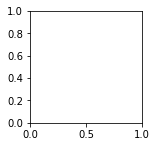

In [49]:
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image

default_path_part = "E:\\7_Seventh Sem\AI\Building Type Classification\Data set\Data set\seg_predict"

Image1 = cv2.imread(default_path_part + "apartment.jpg")
Image2 = cv2.imread(default_path_part + "individual.jpg")
Image3 = cv2.imread(default_path_part + "office.jpg")
Image4 = cv2.imread(default_path_part + "shop.jpg")
Image5 = cv2.imread(default_path_part + "slum.jpg")
Image6 = cv2.imread(default_path_part + "temple.jpg")

fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 3
columns = 3

# showing image
fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.title(pred_dict[default_path_part + "apartment.jpg"])

fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.title(pred_dict[default_path_part + "individual.jpg"])

fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.title(pred_dict[default_path_part + "office.jpg"])

fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.title(pred_dict[default_path_part + "shop.jpg"])

fig.add_subplot(rows, columns, 5)
plt.imshow(Image5)
plt.title(pred_dict[default_path_part + "slum.jpg"])

fig.add_subplot(rows, columns, 6)
plt.imshow(Image6)
plt.title(pred_dict[default_path_part + "temple.jpg"])
